# Geometry

gdsfactory provides you with some geometric functions

## Boolean / outline / offset / invert
There are several common boolean-type operations available in the geometry library.  These include typical boolean operations (and/or/not/xor), offsetting (expanding/shrinking polygons), outlining, and inverting.

### Boolean


The ``gf.geometry.boolean()`` function can perform AND/OR/NOT/XOR operations, and will return a new geometry with the result of that operation.

2023-12-25 16:58:05.124 | WARNING  | gdsfactory.pdk:get_active_pdk:739 - No active PDK. Activating generic PDK.

2023-12-25 16:58:05.281 | INFO     | gdsfactory.technology.layer_views:__init__:790 - Importing LayerViews from YAML file: '/home/simbil/Github/gdsfactory/gdsfactory/generic_tech/layer_views.yaml'.
2023-12-25 16:58:05.283 | INFO     | gdsfactory.pdk:activate:309 - 'generic' PDK is now active


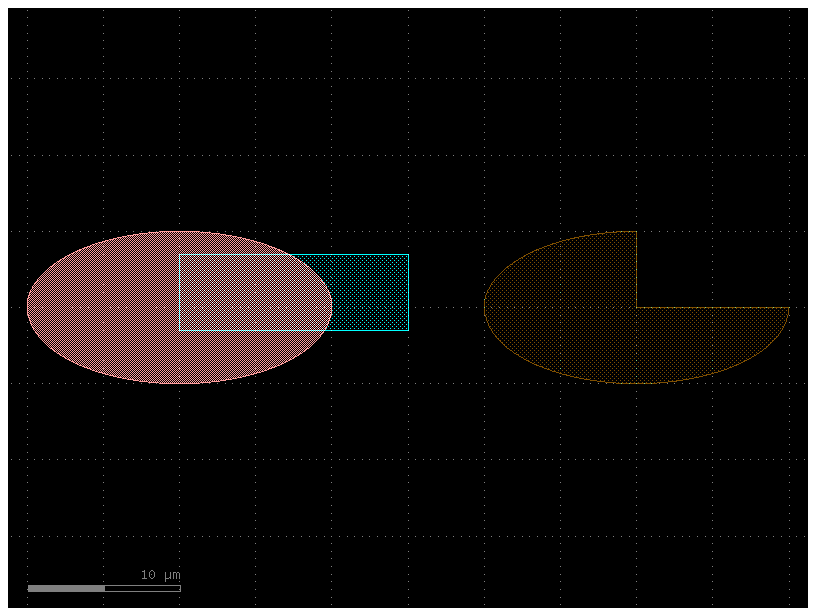

In [1]:
import gdsfactory as gf

E = gf.components.ellipse(radii=(10, 5), layer=(1, 0))
R = gf.components.rectangle(size=[15, 5], layer=(2, 0))
C = gf.geometry.boolean(A=E, B=R, operation="not", precision=1e-6, layer=(3, 0))
# Other operations include 'and', 'or', 'xor', or equivalently 'A-B', 'B-A', 'A+B'

# Plot the originals and the result
D = gf.Component("bool")
D.add_ref(E)
D.add_ref(R).movey(-1.5)
D.add_ref(C).movex(30)
D.plot()

To learn how booleans work you can try all the different operations `not`, `and`, `or`, `xor`

In [2]:
import gdsfactory as gf

operation = "not"
operation = "and"
operation = "or"
operation = "xor"

r1 = (8, 8)
r2 = (11, 4)
r1 = (80, 80)
r2 = (110, 40)

angle_resolution = 0.1

c1 = gf.components.ellipse(radii=r1, layer=(1, 0), angle_resolution=angle_resolution)
c2 = gf.components.ellipse(radii=r2, layer=(1, 0), angle_resolution=angle_resolution)

2023-12-25 16:58:05.776 | INFO     | gdsfactory.component:_write_library:1967 - Wrote to '/tmp/gdsfactory/ellipse_4aa83906.gds'
2023-12-25 16:58:05.777 | INFO     | gdsfactory.component:_write_library:1967 - Wrote to '/tmp/gdsfactory/ellipse_cb56ffd1.gds'


CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 2.62 µs


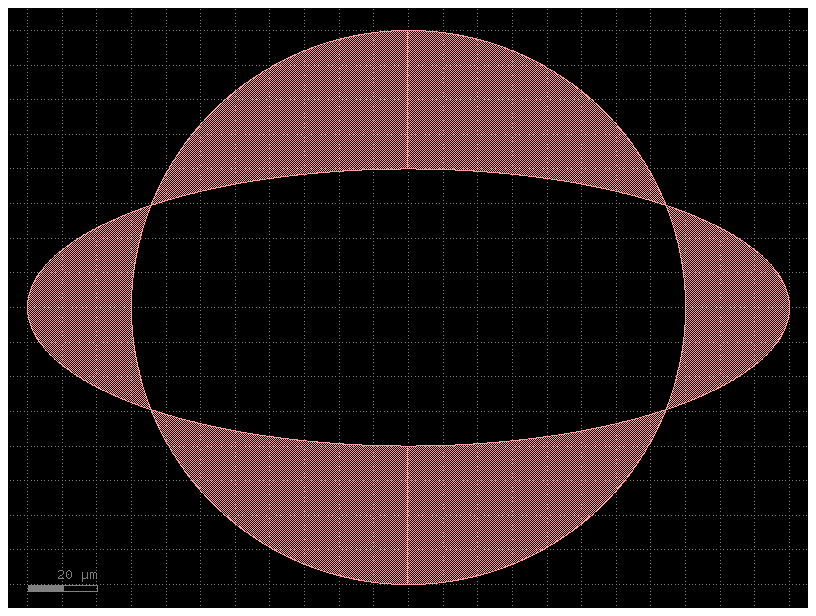

In [3]:
%time

c3 = gf.geometry.boolean_klayout(
    c1, c2, operation=operation, layer1=(1, 0), layer2=(1, 0), layer3=(1, 0)
)  # KLayout booleans
c3.plot()

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 2.86 µs


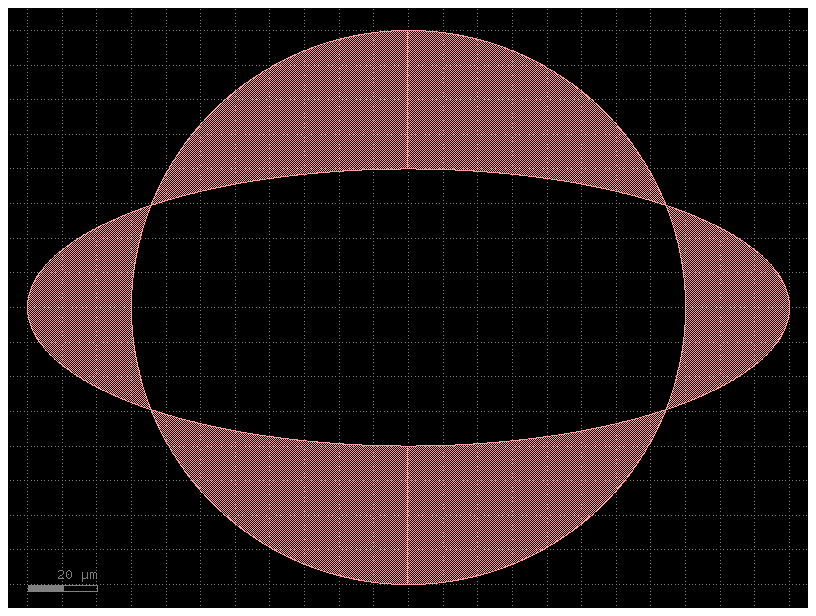

In [4]:
%time
c4 = gf.geometry.boolean(c1, c2, operation=operation)
c4.plot()

### Offset

The ``offset()`` function takes the polygons of the input geometry, combines them together, and expands/contracts them.
The function returns polygons on a single layer and does not respect layers.

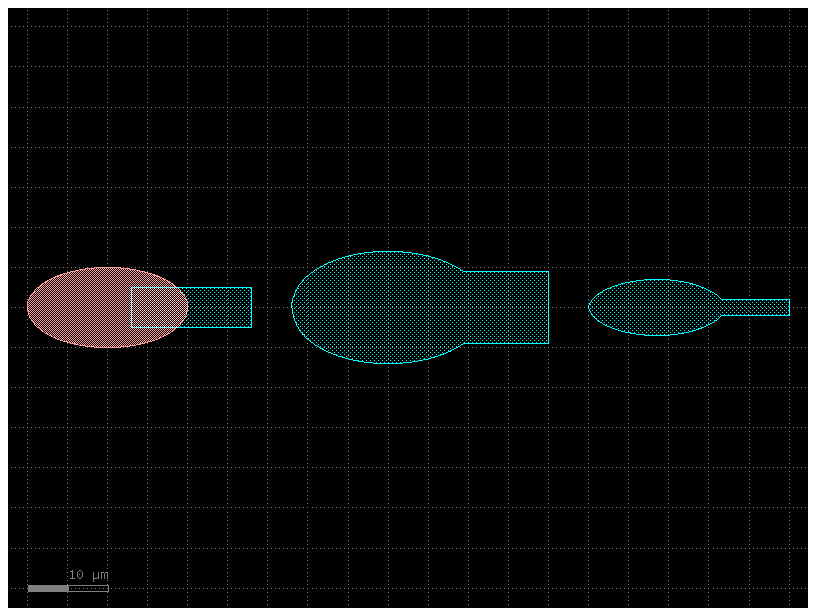

In [5]:
import gdsfactory as gf

# Create `T`, an ellipse and rectangle which will be offset (expanded / contracted)
T = gf.Component("ellipse_and_rectangle")
e = T << gf.components.ellipse(radii=(10, 5), layer=(1, 0))
r = T << gf.components.rectangle(size=[15, 5], layer=(2, 0))
r.move([3, -2.5])

Texpanded = gf.geometry.offset(T, distance=2, precision=1e-6, layer=(2, 0))
Texpanded.name = "expanded"
Tshrink = gf.geometry.offset(T, distance=-1.5, precision=1e-6, layer=(2, 0))
Tshrink.name = "shrink"

# Plot the original geometry, the expanded, and the shrunk versions
offsets = gf.Component("top")
t1 = offsets.add_ref(T)
t2 = offsets.add_ref(Texpanded)
t3 = offsets.add_ref(Tshrink)
offsets.distribute([t1, t2, t3], direction="x", spacing=5)
offsets.plot()

`gf.geometry.offset` is also useful for remove acute angle DRC errors.

You can do a positive offset to grow the polygons followed by a negative offset.

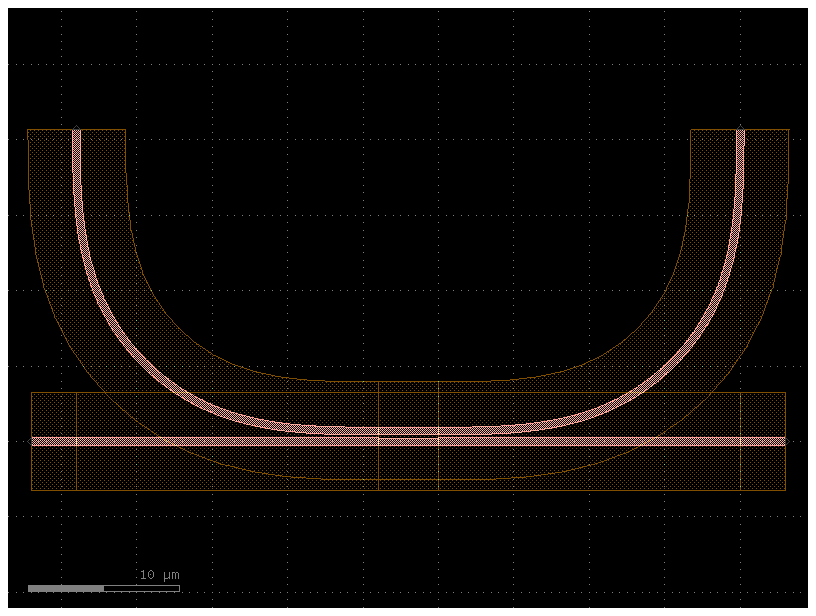

In [6]:
c = gf.Component("demo_dataprep")
c1 = gf.components.coupler_ring(cross_section="xs_rc2", radius=20)
c1.plot()

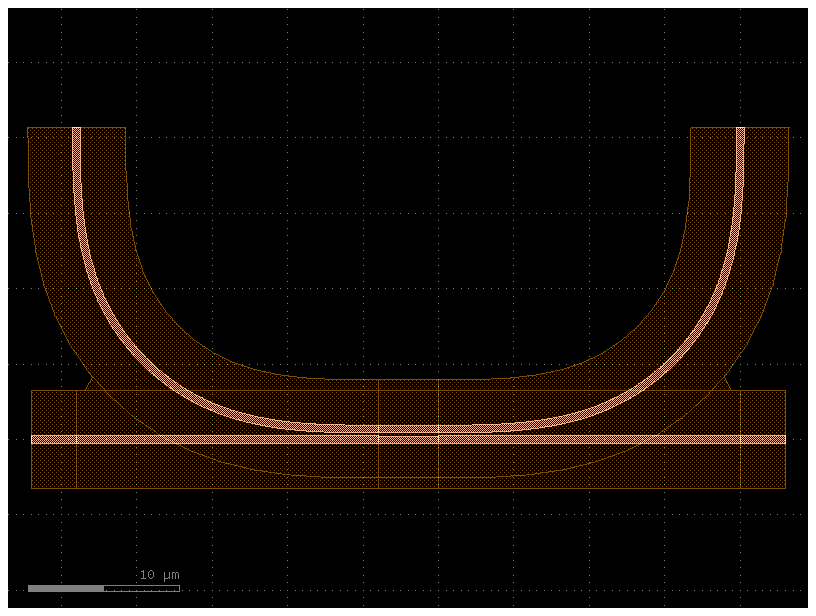

In [7]:
d = 0.8
c2 = gf.geometry.offset(c1, distance=+d, layer=(3, 0))
c3 = gf.geometry.offset(c2, distance=-d, layer=(3, 0))
c << c1
c << c3
c.plot()

You can also run it as a decorator.

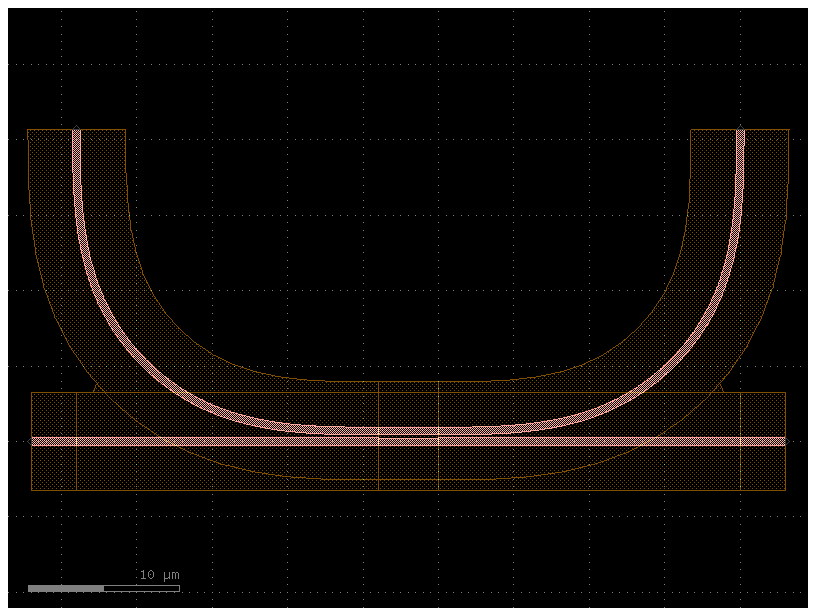

In [8]:
from functools import partial
from gdsfactory.geometry.maskprep import get_polygons_over_under, over_under

over_under_slab = partial(over_under, layers=((3, 0),), distances=(0.5,))

c = gf.components.coupler_ring(
    cross_section="xs_rc2", radius=20, decorator=over_under_slab
)
c.plot()

You can also add extra polygons on top

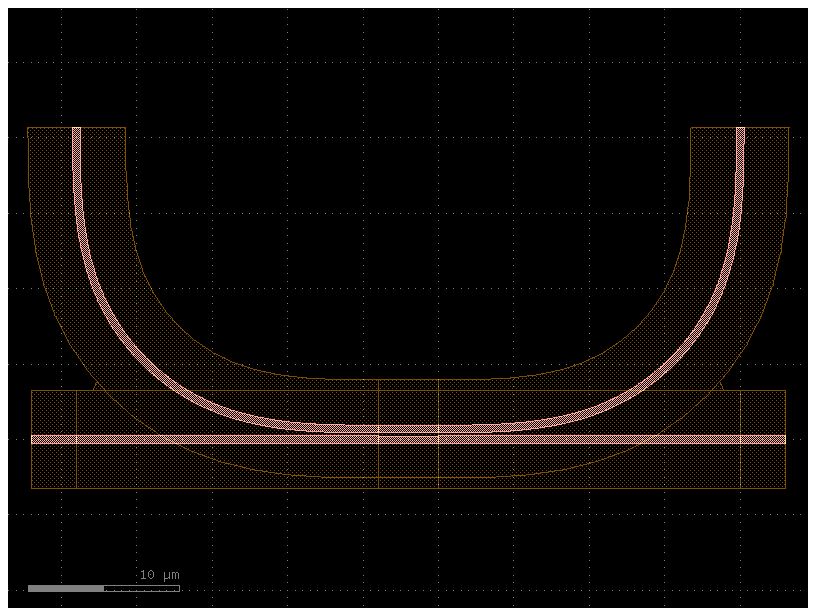

In [9]:
get_polygons_over_under_slab = partial(
    get_polygons_over_under, layers=[(3, 0)], distances=(0.5,)
)
ring = gf.components.coupler_ring(
    cross_section="xs_rc2", radius=20, decorator=over_under_slab
)

c = gf.Component("compnent_clean")
ref = c << ring
polygons = get_polygons_over_under_slab(ref)
c.add(polygons)
c.plot()

The `fix_underplot` decorator performs a combination of offset, AND, and NOT to ensure minimum inclusions of shapes:

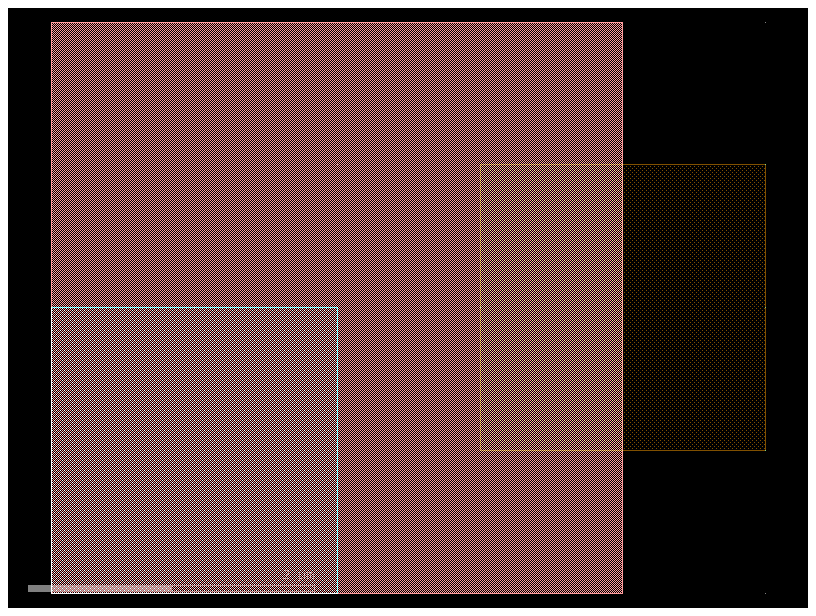

In [37]:
from gdsfactory.geometry.maskprep import fix_underplot

c1 = gf.Component("component_initial")
c1 << gf.components.rectangle(size=(4, 4), layer="WG")
c1 << gf.components.rectangle(size=(2, 2), layer="SLAB150")
slab = c1 << gf.components.rectangle(size=(2, 2), layer="SLAB90")
slab.move((3, 1))
c1.plot()

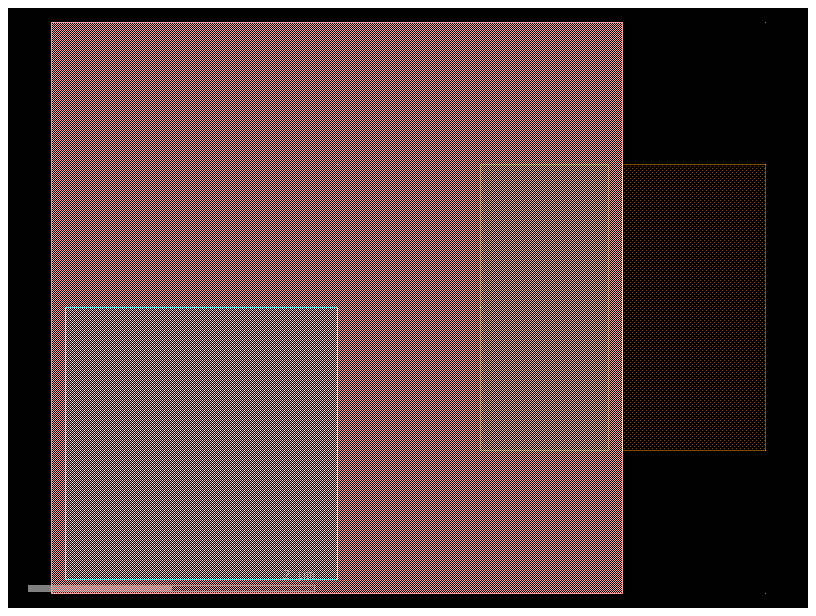

In [38]:
c2 = gf.Component("component_clean")
c2 = fix_underplot(
    component=c1,
    layers_extended=("SLAB150", "SLAB90"),
    layer_reference="WG",
    distance=0.1,
)
c2.plot()

### Outline

The ``outline()`` function takes the polygons of the input geometry then performs an offset and "not" boolean operation to create an outline.  The function returns polygons on a single layer -- it does not respect layers.

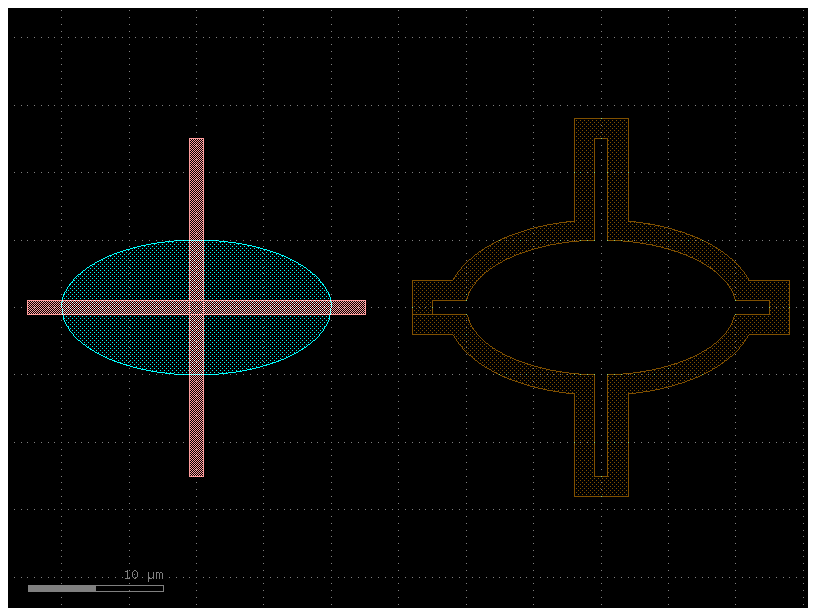

In [12]:
import gdsfactory as gf

# Create a blank device and add two shapes
X = gf.Component("outline_demo")
X.add_ref(gf.components.cross(length=25, width=1, layer=(1, 0)))
X.add_ref(gf.components.ellipse(radii=[10, 5], layer=(2, 0)))

O = gf.geometry.outline(X, distance=1.5, precision=1e-6, layer=(3, 0))

# Plot the original geometry and the result
c = gf.Component("outline_compare")
c.add_ref(X)
c.add_ref(O).movex(30)
c.plot()

The ``open_ports`` argument opens holes in the outlined geometry at each Port location.

- If not False, holes will be cut in the outline such that the Ports are not covered.
- If True, the holes will have the same width as the Ports.
- If a float, the holes will be widened by that value.
- If a float equal to the outline ``distance``, the outline will be flush with the port (useful positive-tone processes).

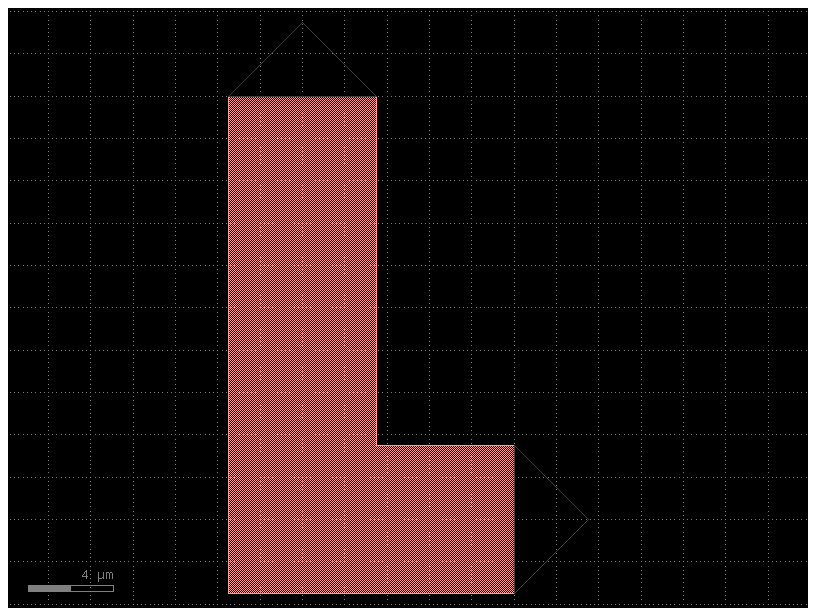

In [13]:
c = gf.components.L(width=7, size=(10, 20), layer=(1, 0))
c.plot()

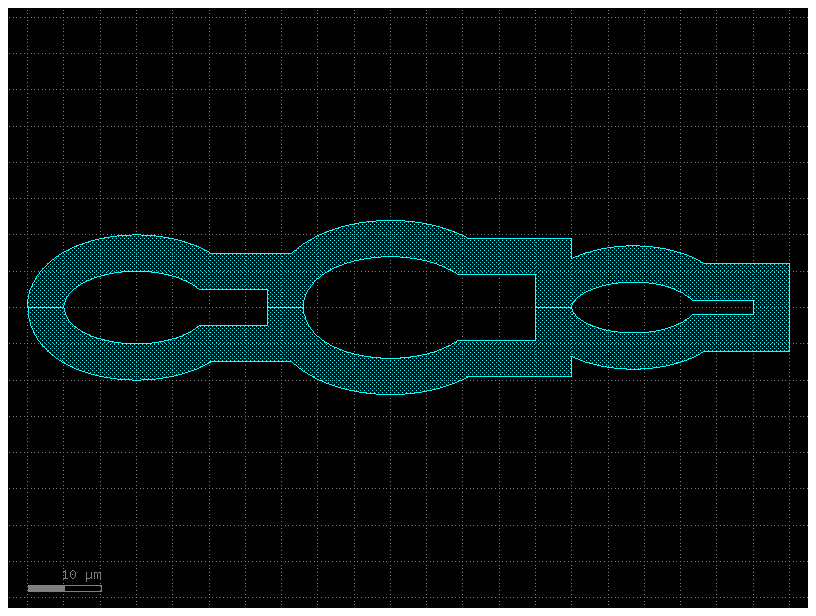

In [14]:
# Outline the geometry and open a hole at each port
c = gf.geometry.outline(offsets, distance=5, open_ports=False, layer=(2, 0))  # No holes
c.plot()

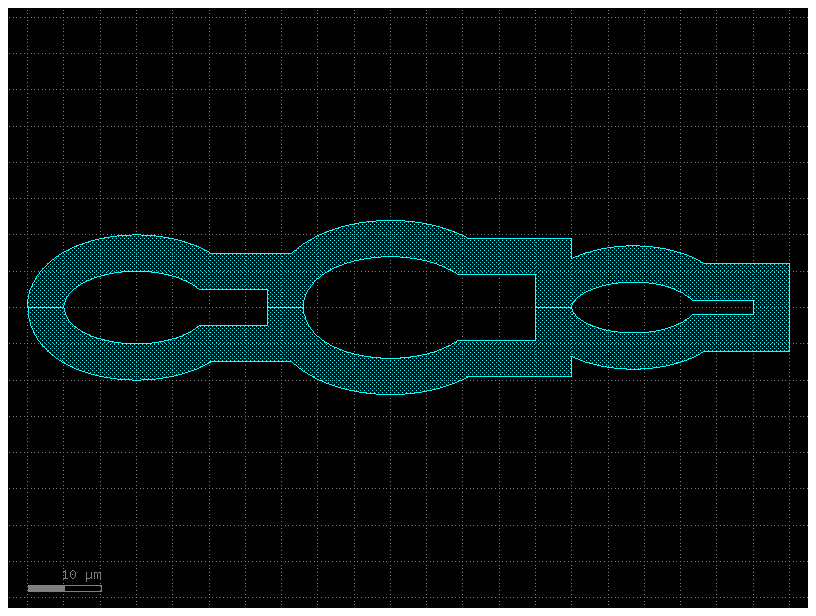

In [15]:
c = gf.geometry.outline(
    offsets, distance=5, open_ports=True, layer=(2, 0)
)  # Hole is the same width as the port
c.plot()

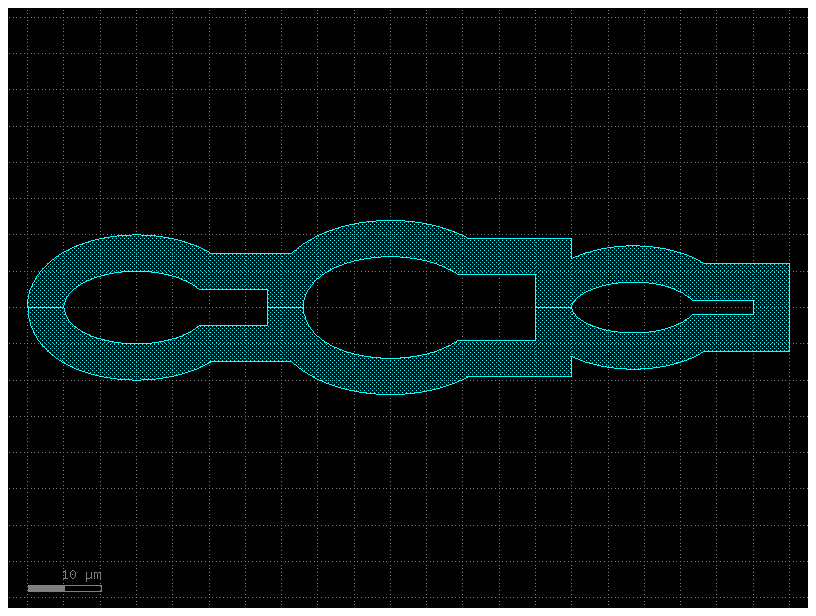

In [16]:
c = gf.geometry.outline(
    offsets, distance=5, open_ports=10, layer=(2, 0)
)  # Change the hole size by entering a float
c.plot()

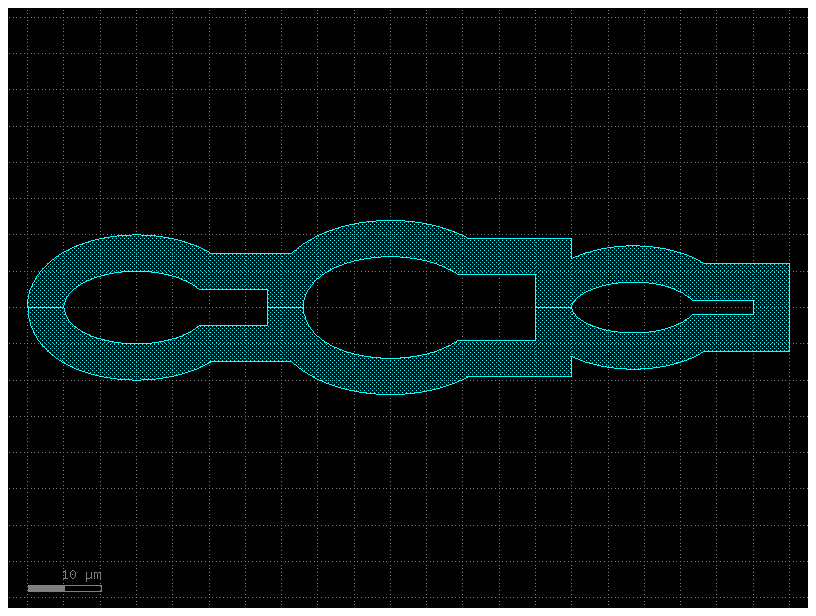

In [17]:
c = gf.geometry.outline(
    offsets, distance=5, open_ports=5, layer=(2, 0)
)  # Creates flush opening (open_ports > distance)
c.plot()

### Invert

Sometimes you need to define not what you keep (positive resist) but what you etch (negative resist). We have some useful functions to invert the tone.
The ``gf.boolean.invert()`` function creates an inverted version of the input geometry.
The function creates a rectangle around the geometry (with extra padding of distance ``border``), then subtract all polygons from all layers from that rectangle, resulting in an inverted version of the geometry.

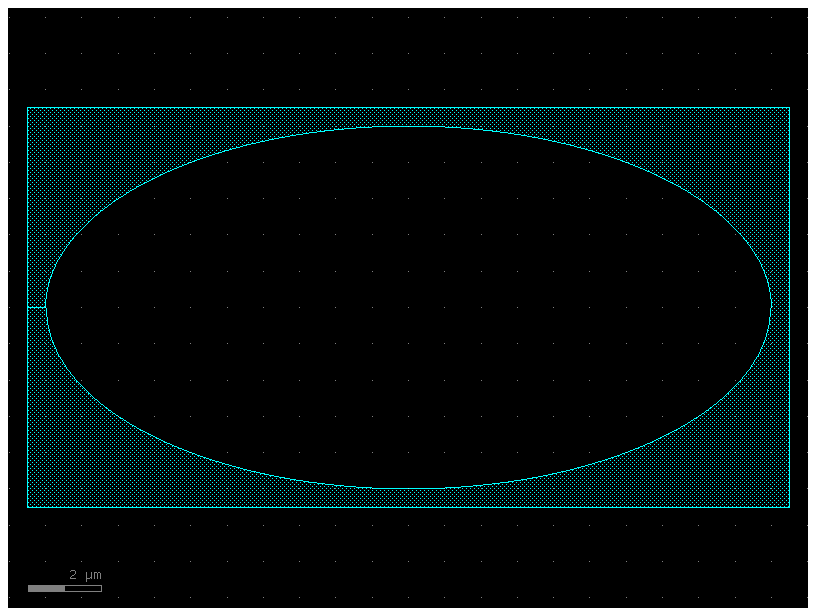

In [18]:
import gdsfactory as gf

E = gf.components.ellipse(radii=(10, 5))
D = gf.geometry.invert(E, border=0.5, precision=1e-6, layer=(2, 0))
D.plot()

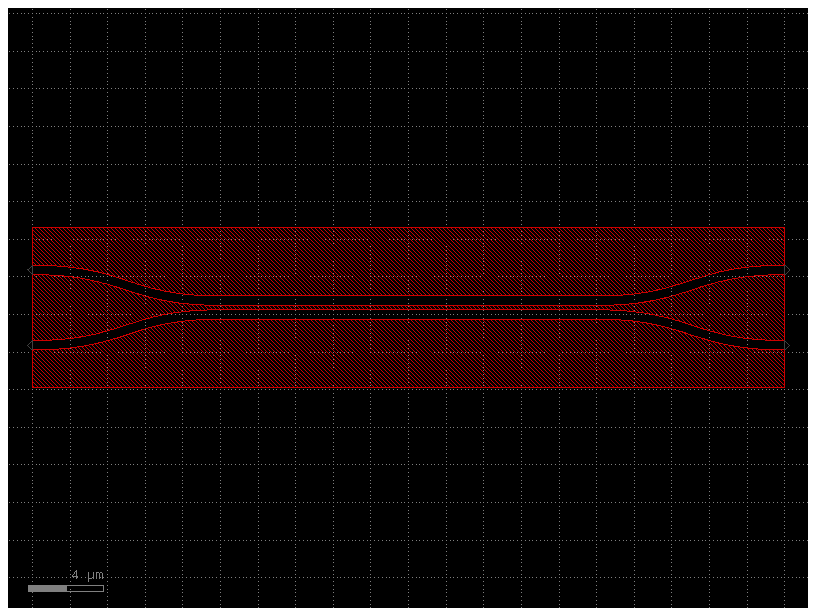

In [19]:
c = gf.components.add_trenches(component=gf.components.coupler)
c.plot()

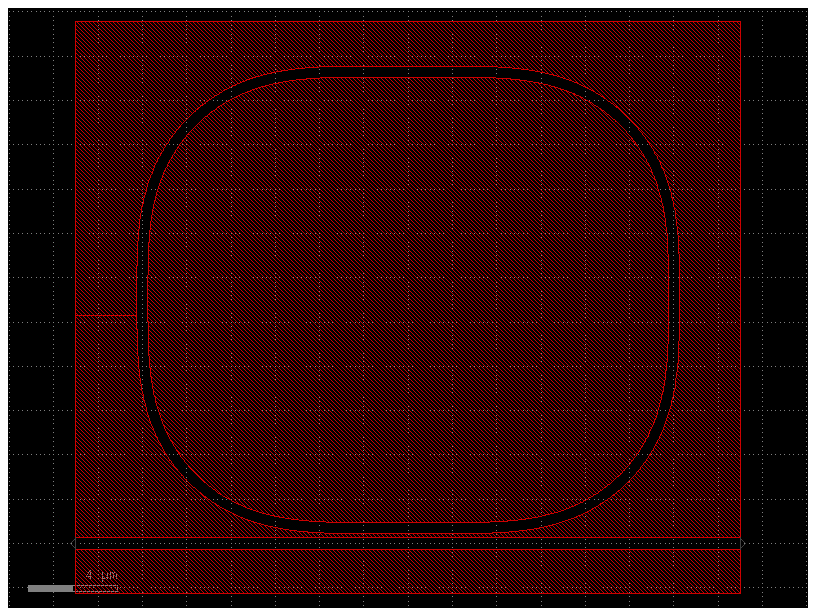

In [20]:
c = gf.components.add_trenches(component=gf.components.ring_single)
c.plot()

### Union

The ``union()`` function is a "join" function, and is functionally identical to the "OR" operation of ``gf.boolean()``.  The one difference is it's able to perform this function layer-wise, so each layer can be individually combined.

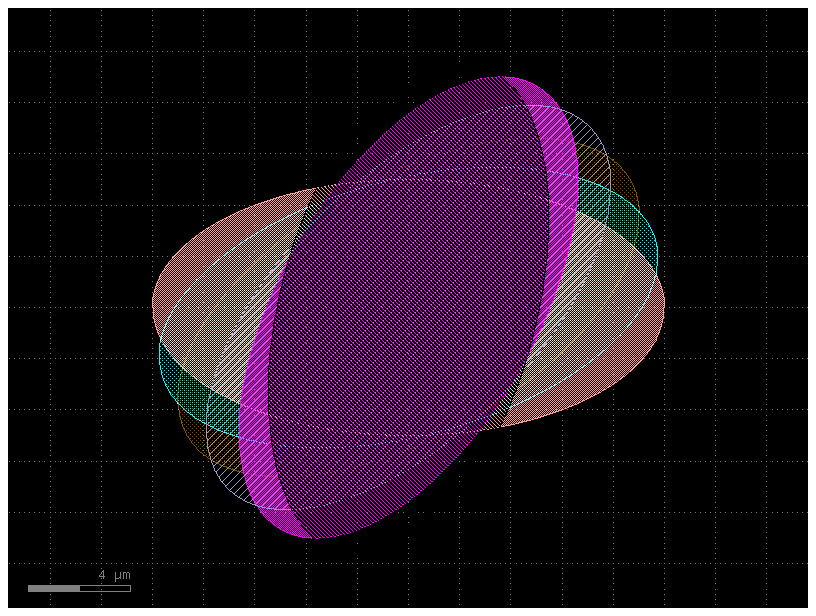

In [21]:
import gdsfactory as gf

D = gf.Component("union")
e0 = D << gf.components.ellipse(layer=(1, 0))
e1 = D << gf.components.ellipse(layer=(2, 0))
e2 = D << gf.components.ellipse(layer=(3, 0))
e3 = D << gf.components.ellipse(layer=(4, 0))
e4 = D << gf.components.ellipse(layer=(5, 0))
e5 = D << gf.components.ellipse(layer=(6, 0))

e1.rotate(15 * 1)
e2.rotate(15 * 2)
e3.rotate(15 * 3)
e4.rotate(15 * 4)
e5.rotate(15 * 5)

D.plot()

2023-12-25 16:58:07.688 | INFO     | gdsfactory.klive:show:55 - Message from klive: {"version": "0.2.2", "type": "open", "file": "/tmp/gdsfactory/union_c89e9033.gds"}


union_c89e9033: uid b3a2920a, ports [], references [], 1 polygons

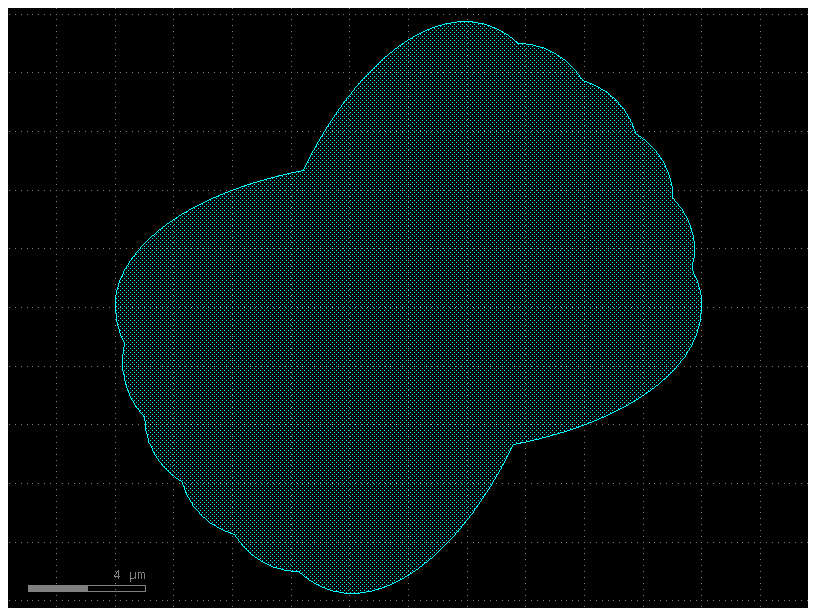

In [22]:
# We have two options to unioning - take all polygons, regardless of
# layer, and join them together (in this case on layer (2,0) like so:
D_joined = gf.geometry.union(D, by_layer=False, layer=(2, 0))
D_joined

2023-12-25 16:58:07.826 | INFO     | gdsfactory.klive:show:55 - Message from klive: {"version": "0.2.2", "type": "open", "file": "/tmp/gdsfactory/union_40184f65.gds"}


union_40184f65: uid 6495a16d, ports [], references [], 6 polygons

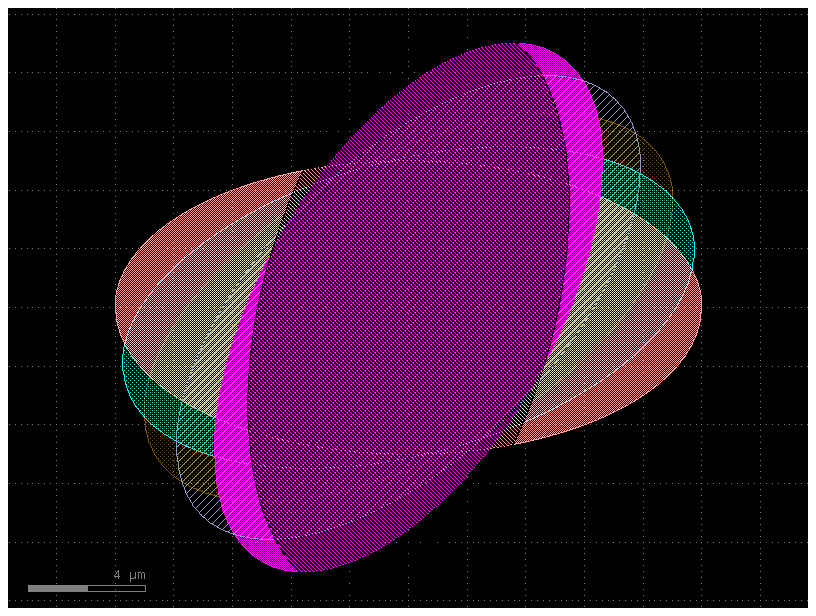

In [23]:
# Or we can perform the union operate by-layer
D_joined_by_layer = gf.geometry.union(D, by_layer=True)
D_joined_by_layer

### XOR / diff

The ``xor_diff()`` function can be used to compare two geometries and identify where they are different.  Specifically, it performs a layer-wise XOR operation.  If two geometries are identical, the result will be an empty Component.  If they are not identical, any areas not shared by the two geometries will remain.

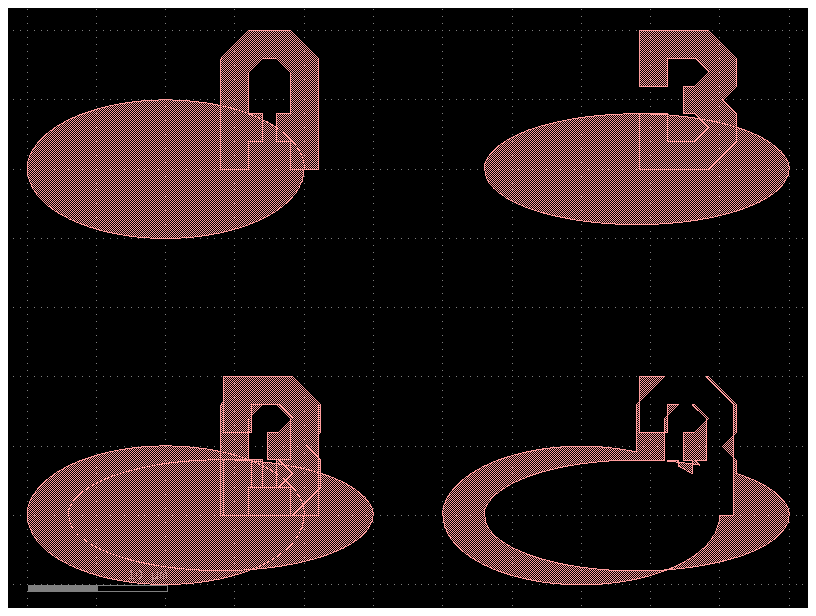

In [24]:
import gdsfactory as gf

A = gf.Component("A")
A.add_ref(gf.components.ellipse(radii=[10, 5], layer=(1, 0)))
A.add_ref(gf.components.text("A")).move([3, 0])

B = gf.Component("B")
B.add_ref(gf.components.ellipse(radii=[11, 4], layer=(1, 0))).movex(4)
B.add_ref(gf.components.text("B")).move([3.2, 0])
X = gf.geometry.xor_diff(A=A, B=B, precision=1e-6)

# Plot the original geometry and the result
# Upper left: A / Upper right: B
# Lower left: A and B / Lower right: A xor B "diff" comparison
D = gf.Component("xor_diff")
D.add_ref(A).move([-15, 25])
D.add_ref(B).move([15, 25])
D.add_ref(A).movex(-15)
D.add_ref(B).movex(-15)
D.add_ref(X).movex(15)
D.plot()

## Trim

`trim` returns the portion of that component within that domain preserving all layers and (possibly) ports.

It's like the opposite of "add_padding", and also allows non-rectangular shapes for the padding removal.

Useful when resizing an existing component for simulations

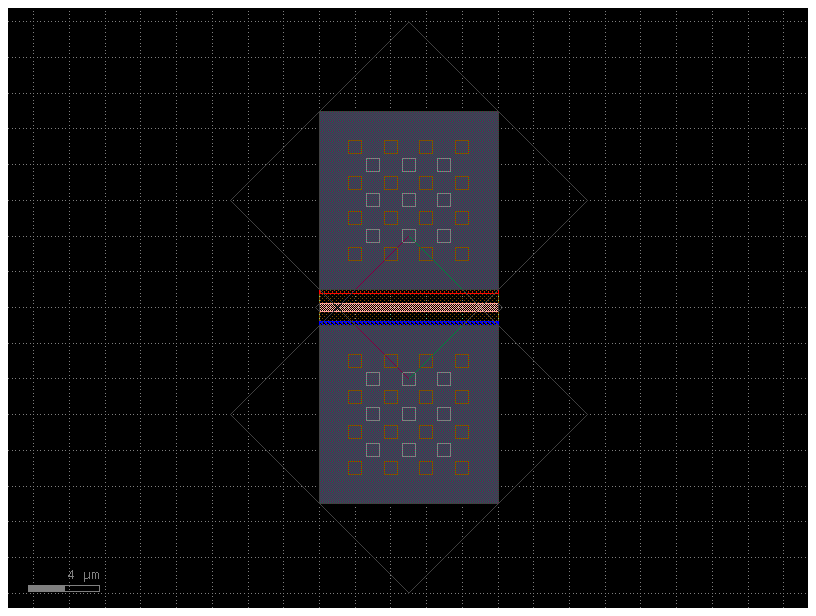

In [25]:
c = gf.components.straight_pin(length=10, taper=None)
c.plot()

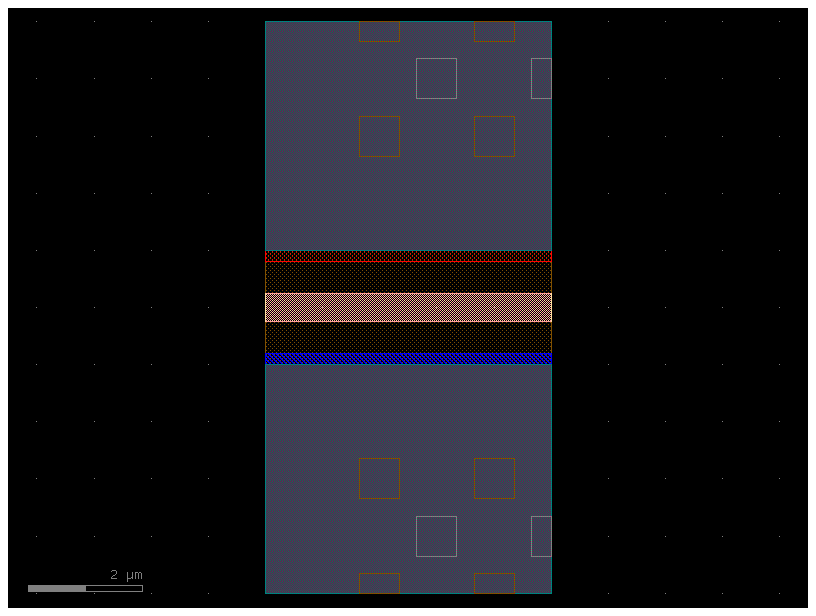

In [26]:
trimmed_c = gf.geometry.trim(component=c, domain=[[0, -5], [0, 5], [5, 5], [5, -5]])
trimmed_c.plot()

## Importing GDS files

`gf.import_gds()` allows you to easily import external GDSII files.  It imports a single cell from the external GDS file and converts it into a gdsfactory component.

2023-12-25 16:58:08.218 | INFO     | gdsfactory.component:_write_library:1967 - Wrote to 'myoutput.gds'


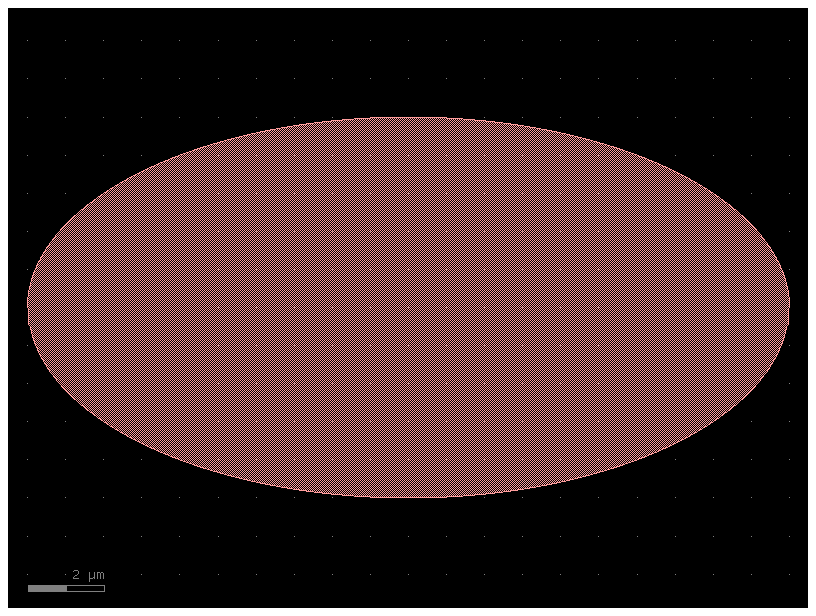

In [27]:
D = gf.components.ellipse()
D.write_gds("myoutput.gds")
D2 = gf.import_gds(gdspath="myoutput.gds", cellname=None, flatten=False)
D2.plot()

## Copying and extracting geometry

/home/simbil/Github/gdsfactory/gdsfactory/component.py:1623: UserWarning: Unnamed cells, 1 in 'Unnamed_f6574197'
  gdspath = component.write_gds(logging=False)


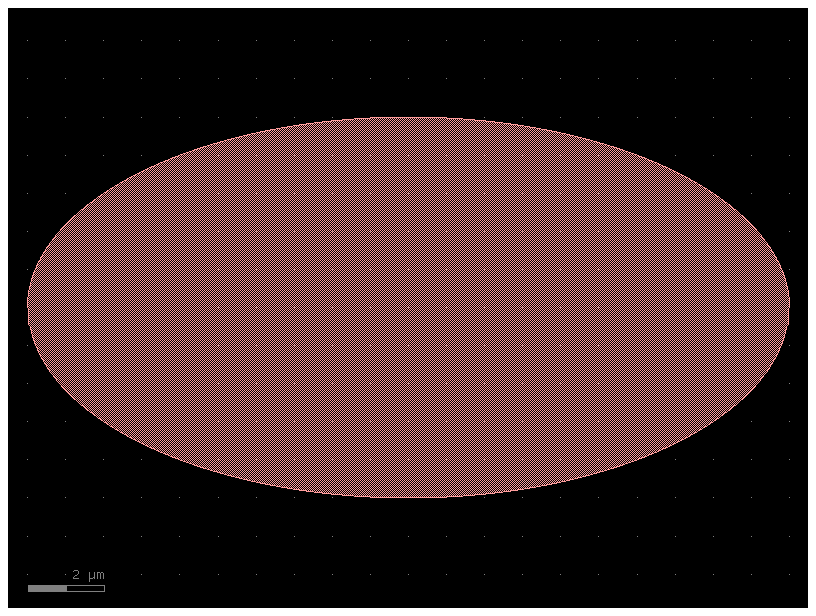

In [28]:
E = gf.Component()
E.add_ref(gf.components.ellipse(layer=(1, 0)))
D = E.extract(layers=[(1, 0)])
D.plot()

/home/simbil/Github/gdsfactory/gdsfactory/component.py:1623: UserWarning: Unnamed cells, 1 in 'Unnamed_d01b9986'
  gdspath = component.write_gds(logging=False)


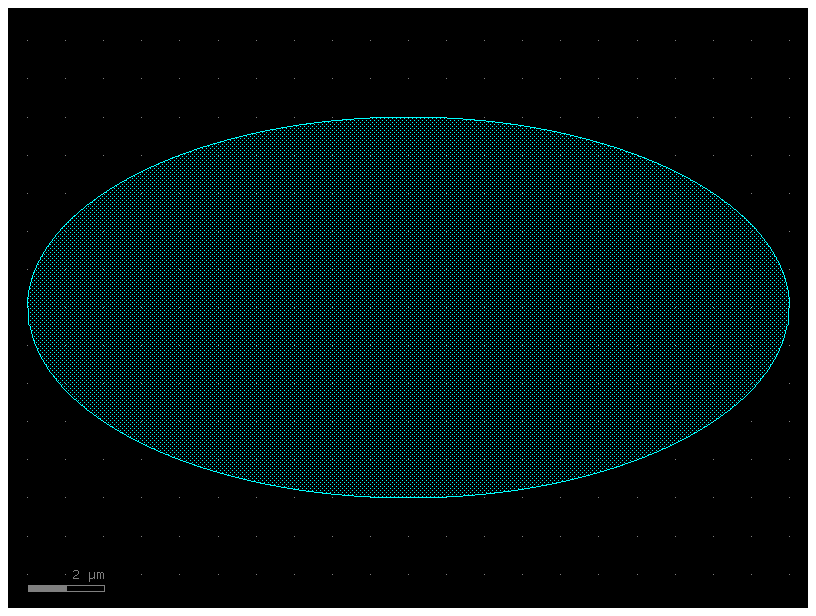

In [29]:
import gdsfactory as gf

X = gf.components.ellipse(layer=(2, 0))
c = X.copy()
c.plot()

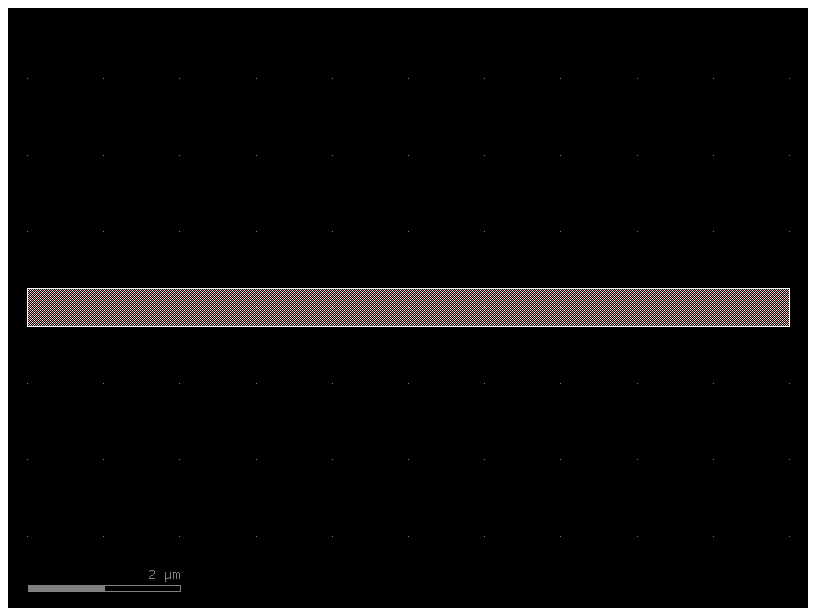

In [30]:
c_copied_layers = gf.components.copy_layers(
    gf.components.straight, layers=((1, 0), (2, 0))
)
c_copied_layers.plot()

## Import Images into GDS

You can import your logo into GDS using the conversion from numpy arrays.

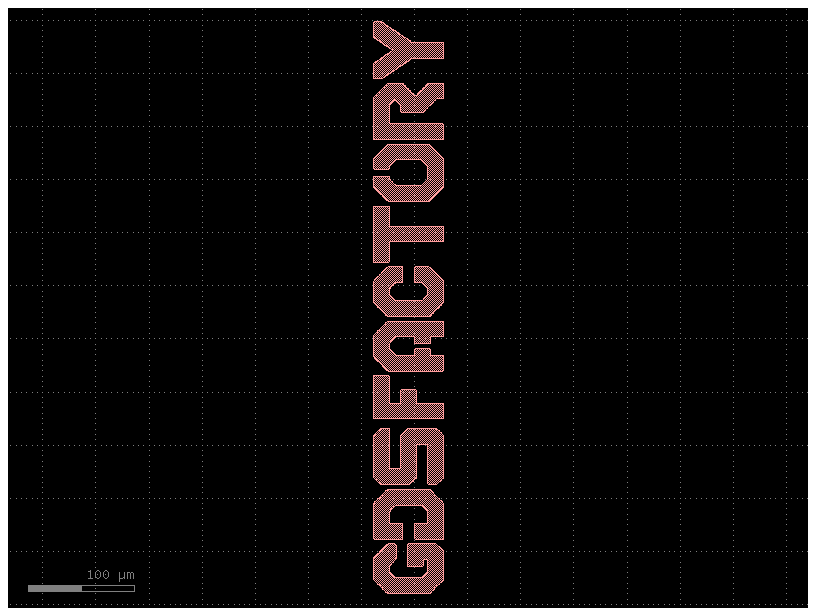

In [31]:
from gdsfactory.config import PATH
from gdsfactory.read.from_np import from_image
import gdsfactory as gf

c = from_image(
    PATH.module / "samples" / "images" / "logo.png", nm_per_pixel=500, invert=False
)
c.plot()

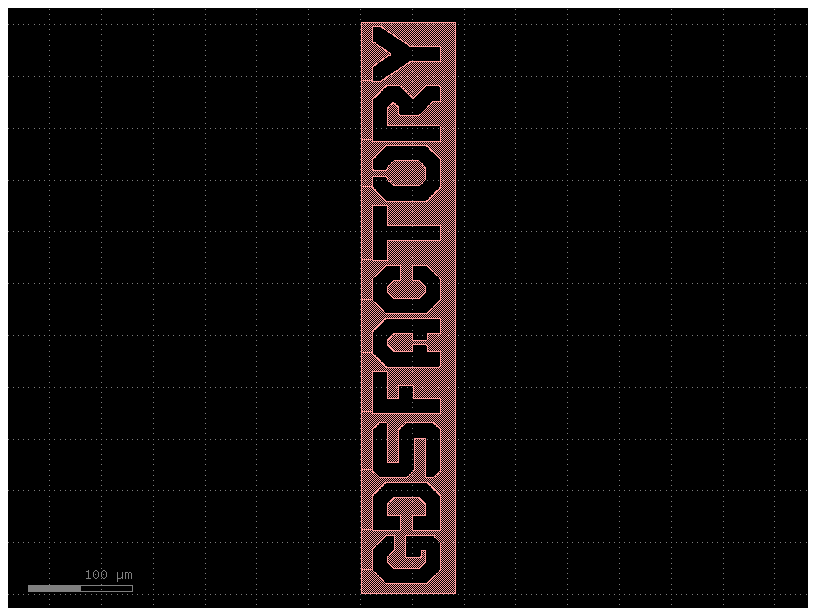

In [32]:
c = from_image(
    PATH.module / "samples" / "images" / "logo.png", nm_per_pixel=500, invert=True
)
c.plot()

## Dummy Fill / Tiling

To keep constant density in some layers you can add dummy fill rectangles.

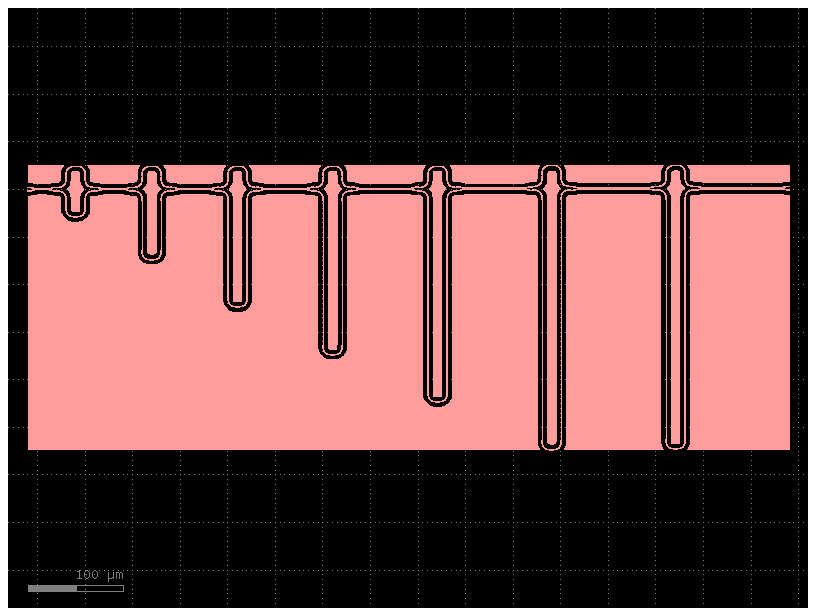

In [33]:
coupler_lengths = [10, 20, 30, 40, 50, 60, 70, 80]
coupler_gaps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
delta_lengths = [10, 100, 200, 300, 400, 500, 500]

mzi = gf.components.mzi_lattice(
    coupler_lengths=coupler_lengths,
    coupler_gaps=coupler_gaps,
    delta_lengths=delta_lengths,
)

# Add fill
c = gf.Component("component_with_fill")
layers = [(1, 0)]
fill_size = [0.5, 0.5]

c << gf.fill_rectangle(
    mzi,
    fill_size=fill_size,
    fill_layers=layers,
    margin=5,
    fill_densities=[0.8] * len(layers),
    avoid_layers=layers,
)

c << mzi
c.plot()

For large fill regions you can use klayout.

### Custom fill cell

You can use a custom cell as a fill.

2023-12-25 16:58:09.525 | INFO     | gdsfactory.component:_write_library:1967 - Wrote to 'mzi_fill.gds'


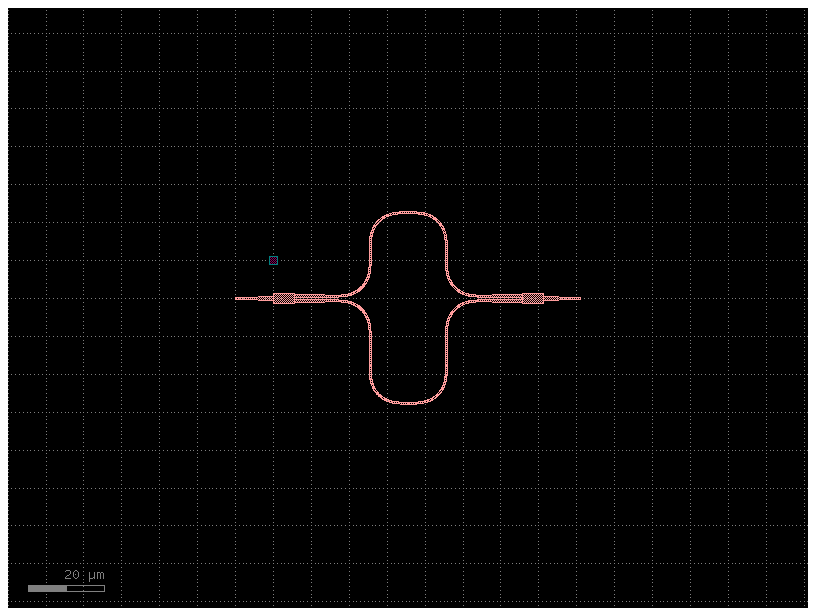

In [34]:
import gdsfactory as gf
from gdsfactory.geometry.fill_klayout import fill


@gf.cell
def cell_with_pad():
    c = gf.Component()
    c << gf.components.mzi(decorator=gf.add_padding)
    pad = c << gf.components.pad(size=(2, 2))
    pad.movey(10)
    return c


c = cell_with_pad()
gdspath = c.write_gds("mzi_fill.gds")
c.plot()

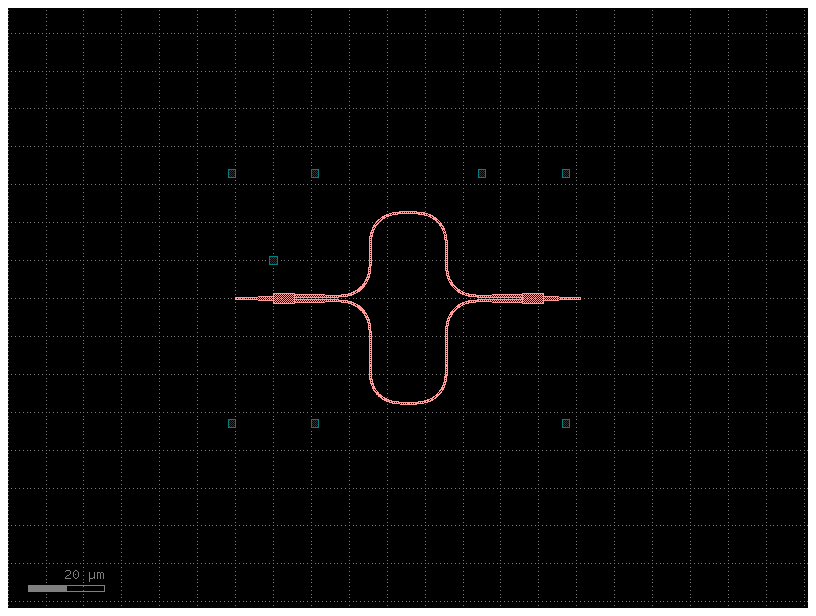

In [35]:
spacing = 20
fill(
    gdspath,
    fill_layers=("WG",),
    layer_to_fill=(67, 0),
    layers_to_avoid=(((1, 0), 0), ((49, 0), 0)),
    fill_cell_name="pad_size2__2",
    create_new_fill_cell=False,
    fill_spacing=(spacing, spacing),
    fill_size=(1, 1),
    include_original=True,
    layer_to_fill_margin=25,
)

c_fill = gf.import_gds(gdspath)
c_fill.plot()

### Tiling processor

For big layouts you can should use klayout tiling processor.

2023-12-25 16:58:09.814 | INFO     | kfactory.utils.fill:fill_tiled:201 - filling ToFill with fill
2023-12-25 16:58:09.876 | INFO     | kfactory.utils.fill:fill_tiled:204 - done with filling ToFill


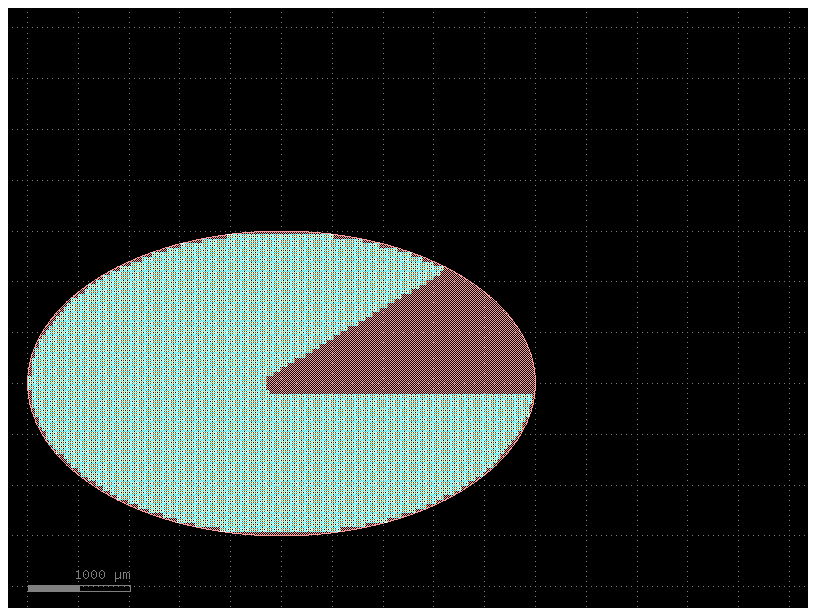

In [36]:
import kfactory as kf

import gdsfactory as gf
from kfactory.utils.fill import fill_tiled

c = kf.KCell("ToFill")
c.shapes(kf.kcl.layer(1, 0)).insert(
    kf.kdb.DPolygon.ellipse(kf.kdb.DBox(5000, 3000), 512)
)
c.shapes(kf.kcl.layer(10, 0)).insert(
    kf.kdb.DPolygon(
        [kf.kdb.DPoint(0, 0), kf.kdb.DPoint(5000, 0), kf.kdb.DPoint(5000, 3000)]
    )
)

fc = kf.KCell("fill")
fc.shapes(fc.kcl.layer(2, 0)).insert(kf.kdb.DBox(20, 40))
fc.shapes(fc.kcl.layer(3, 0)).insert(kf.kdb.DBox(30, 15))

# fill.fill_tiled(c, fc, [(kf.kcl.layer(1,0), 0)], exclude_layers = [(kf.kcl.layer(10,0), 100), (kf.kcl.layer(2,0), 0), (kf.kcl.layer(3,0),0)], x_space=5, y_space=5)
fill_tiled(
    c,
    fc,
    [(kf.kcl.layer(1, 0), 0)],
    exclude_layers=[
        (kf.kcl.layer(10, 0), 100),
        (kf.kcl.layer(2, 0), 0),
        (kf.kcl.layer(3, 0), 0),
    ],
    x_space=5,
    y_space=5,
)

gdspath = "mzi_fill.gds"
c.write(gdspath)
c = gf.import_gds(gdspath)
c.plot()